# "The Experiment"

---

## Scenario
Three intrepid scientists Alice, Bob, and Carol are embarking on a series of groundbreaking experiments.

The three scientists will conduct one experiment per day.  No two experiments can be done on the same date.  At the start the experiment, the  will draw straws to decide who will run the experiment that day.  During each experiment, they will acquire 7 grayscale images of mysterios blobs.  Therefore, during each experiment, they will store the date of the experiment, the name of the person who did the experiment, and the acquired images.

The acquisition of one experiment will be implemented by the function `acquire`.

In [12]:
%%capture
%pylab inline

## Preliminaries 
These 

In [ ]:
# %load ../manuscript/code/experiment_preliminaries.py
import numpy as np
import time
from scipy import ndimage


def make_image(seed=None, ncells=100, size=256):
    """
    make blob image
    """
    np.random.seed(seed)
    im = np.zeros((size, size))
    points = (size*np.random.random((2, ncells))).astype(np.int)
    im[points[0], points[1]]= 1 + 0.1*np.random.normal(size=ncells)
    return ndimage.gaussian_filter(im, sigma=size/(6.*np.sqrt(ncells)))


class BlobFail(Exception):
    pass


def find_blobs(im, fail_rate=0.01):
    """
    Generates x, y coordinates of blobs detected in image im.
    Intentionally fails (raises BlobFail) randomly at fail_rate.
    """
    for y, x in zip(*np.where(
            im > ndimage.filters.percentile_filter(im, 85, size=3))):
        if np.random.random() < fail_rate:
            print("Fail!", flush=True)
            raise BlobFail
        yield x, y


(-0.5, 255.5, 255.5, -0.5)

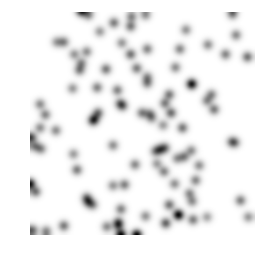

In [4]:
# demonstrate image generation
im = make_image()
imshow(im, cmap='gray_r');
axis('off')

In [5]:
import datajoint as dj
schema = dj.schema('dimitri_blobs', locals())

DataJoint 0.4.4 (December 6, 2016)
Loading local settings from /Users/dimitri/.datajoint_config.json
Connecting dimitri@at-database.ad.bcm.edu:3306


In [ ]:
# %load ../manuscript/code/experiment_scientist.py
@schema 
class Scientist(dj.Lookup):
    definition = """    # scientists in the lab
    name : varchar(8)   # scientist name
    """    
    contents = [['Alice'], ['Bob'], ['Carol'], ['Dave']]


In [ ]:
# %load ../manuscript/code/experiment_experiment.py
class Experiment(dj.Manual):
    definition = """ # daily experiment
    exp_date : date   # experiment date
    --- 
    -> Scientist
    notes="" : varchar(255)  # free notes about the experiment
    """


In [ ]:
# %load ../manuscript/code/experiment_enter.py
e = Experiment()

# enter one at a time
e.insert1(dict(exp_date="2016-10-01", name="Carol", notes="awesome data!"))

# enter with default attribute value
e.insert1(dict(exp_date="2016-10-02", name="Bob"))

# enter by position (without attribute names)
e.insert1(('2016-10-03', 'Alice', 'found a piece of dark matter.'))

# enter several tuples together
e.insert((
        ("2016-10-04", "Carol", "stunning!"),
        ("2016-10-05", "Bob", "inexplicable patterns."),
        ("2016-10-06", "Alice", "A boson got loose.")
    ))

In [9]:
Experiment()

exp_date,name,notes
2016-10-01,Carol,awesome data!
2016-10-02,Bob,
2016-10-03,Alice,found a piece of dark matter.
2016-10-04,Carol,stunning!
2016-10-05,Bob,inexplicable patterns.
2016-10-06,Alice,A boson got loose.


In [8]:
import numpy as np

@schema
class Acquire(dj.Imported):
    definition = """   # Image data from one experiment
    -> Experiment 
    ---
    timestamp = CURRENT_TIMESTAMP  : timestamp  
    """
    
    class Image(dj.Part):
        definition = """
        -> Acquire
        image_id : tinyint unsigned   # image number within each experiment
        ---
        image : longblob  # acquired image
        """
        
    def _make_tuples(self, key):
        print('Populating:', key)
        self.insert1(key)
        number_of_images = np.random.randint(20)
        part = self.Image()
        for i in range(number_of_images):
            print(end='.')
            part.insert1(
                dict(key, image_id=i, image=make_image()))
        print('done')

In [9]:
Acquire().populate()

Populating: {'exp_date': datetime.date(2016, 10, 3)}
.............done
Populating: {'exp_date': datetime.date(2016, 10, 6)}
..............done
Populating: {'exp_date': datetime.date(2016, 10, 2)}
.done
Populating: {'exp_date': datetime.date(2016, 10, 5)}
..............done
Populating: {'exp_date': datetime.date(2016, 10, 1)}
.......done
Populating: {'exp_date': datetime.date(2016, 10, 4)}
...................done


In [10]:
@schema
class Localize(dj.Computed):
    definition = """   # Image data from one experiment
    -> Acquire.Image
    """
    
    class Blob(dj.Part):
        definition = """
        -> Localize
        blob_id : tinyint unsigned   # blob within each image
        ---
        x : float  # x-coordinate
        y : float  # y-coordinate
        amplitude : float  # amptlitude
        """
        
    def _make_tuples(self, key):
        print('Populating:', key)
        self.insert1(key)
        img = (Acquire.Image() & key).fetch1['image']
        part = self.Blob()
        for i, (x, y) in enumerate(find_blobs(img)):
            print(flush=True, end='.')
            part.insert1(dict(key, blob_id=i, x=x, y=y, amplitude=img[y,x]))
        print('done')

In [11]:
Localize().populate(suppress_errors=True);

Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 0}
................................................Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 1}
....................Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 2}
............................Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 3}
........................................................................done
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 4}
.................................................Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 5}
.........................................................................done
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 6}
........................................................................done
Populating: {'exp_date': datetime.date(2016, 10, 2), 'image_id': 0}
.......................................................

In [12]:
Localize().progress();

Localize             Completed 32 of 68 (47.1%)   2016-11-21 15:55:32


In [13]:
@schema
class Localize(dj.Computed):
    definition = """   # Image data from one experiment
    -> Acquire.Image
    """
    
    class Blob(dj.Part):
        definition = """
        -> Localize
        blob_id : tinyint unsigned   # blob within each image
        ---
        x : float  # x-coordinate
        y : float  # y-coordinate
        amplitude : float  # amptlitude
        """
        
    def _make_tuples(self, key):
        print('Populating:', key)
        self.insert1(key)
        img = (Acquire.Image() & key).fetch1['image']
        self.Blob().insert((
                dict(key, blob_id=i, x=x, y=y, amplitude=img[y,x])
                for i,(x,y) in enumerate(find_blobs(img))
            ))
        print('done')

In [14]:
Localize().populate(suppress_errors=True);

Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 0}
Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 1}
Fail!
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 2}
done
Populating: {'exp_date': datetime.date(2016, 10, 1), 'image_id': 4}
done
Populating: {'exp_date': datetime.date(2016, 10, 3), 'image_id': 0}
done
Populating: {'exp_date': datetime.date(2016, 10, 3), 'image_id': 1}
done
Populating: {'exp_date': datetime.date(2016, 10, 3), 'image_id': 3}
done
Populating: {'exp_date': datetime.date(2016, 10, 3), 'image_id': 7}
done
Populating: {'exp_date': datetime.date(2016, 10, 3), 'image_id': 12}
Fail!
Populating: {'exp_date': datetime.date(2016, 10, 4), 'image_id': 2}
Fail!
Populating: {'exp_date': datetime.date(2016, 10, 4), 'image_id': 4}
done
Populating: {'exp_date': datetime.date(2016, 10, 4), 'image_id': 6}
Fail!
Populating: {'exp_date': datetime.date(2016, 10, 4), 'image_id': 7}
Fail!
Populating: {'exp_date': datetime.date(2016,

In [15]:
Localize().progress();

Localize             Completed 48 of 68 (70.6%)   2016-11-21 15:55:46


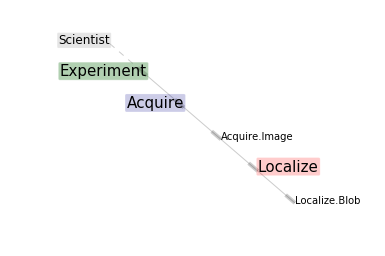

In [16]:
dj.ERD(schema).draw()

In [17]:
Scientist() & Experiment()

name
Alice
Bob
Carol


In [18]:
Scientist().aggr(Experiment(), n='count(exp_date)')

name,n
Alice,2
Bob,2
Carol,2


In [19]:
Acquire.Image() & (Experiment() & {'name': 'Alice'})

exp_date,image_id,image
2016-10-03,8,=BLOB=
2016-10-03,9,=BLOB=
2016-10-03,10,=BLOB=
2016-10-03,11,=BLOB=
2016-10-03,12,=BLOB=
2016-10-03,0,=BLOB=
2016-10-03,1,=BLOB=


In [20]:
acquired = Scientist().aggr(Experiment()*Acquire.Image(), n='count(image_id)') 
acquired

name,n
Alice,27
Bob,15
Carol,26


In [21]:
analyzed = Scientist().aggr(Experiment()*Localize(), m='count(image_id)')
analyzed

name,m
Alice,20
Bob,11
Carol,17


In [22]:
acquired*analyzed

name,n,m
Alice,27,20
Bob,15,11
Carol,26,17


In [23]:
(analyzed*acquired).proj(pcent = '100*m/n')

name,pcent
Alice,74.0741
Bob,73.3333
Carol,65.3846


In [24]:
schema.drop()

Proceed to delete entire schema `dimitri_blobs`? [yes, No]: no
